<h1 style="color:darkred; font-family:candara; font-size:400%; text-align:center;"> 
    Pneumonia detection with CNN
</h1>

***

[Pneumonia](https://en.wikipedia.org/wiki/Pneumonia) is a lung infection that produces inflammation and that may appear either in one or both lungs. 
More specifically, the infection causes inflammation in the small air sacs in the lungs, otherwise known as [**alveoli**](https://en.wikipedia.org/wiki/Pulmonary_alveolus). 
There are several reasons for this disease to appear, for example bacteria, viruses, and funghi might lead to it. 

The alveoli fill with fluid or pus, and make it difficult to breathe. 
Typical symptoms include cough (either dry or productive), chest pain, fever and difficulty breathing. 
This is one of the most dangerous diseases among all age groups, resulting in **1.4 million deaths in 2010** (7% of the world's yearly total) and in 2016 it was the 4th leading cause of death in the world, resulting in **3.0 million deaths worldwide**. 
Pneumonia is considered to be the most deadly communicable disease as of 2016 and is most dangerous for children less than 5 and people over 75 years. 


In the following project we will try to create a neural network that attempts to correctly predict whether or not a patient has pneumonia only by looking at chest X-Rays of people with and without the disease.

The database we took to create this neural network can be found in [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). 


To begin with, let's do some imports of some of the packages we will be using:





In [1]:
# Most of the necessary packages
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns; sns.set();
import tensorflow as tf
import os
import zipfile # Manipulate zipfiles

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing data

We first need to get access to this Kaggle database.



In [2]:
# Select and download database
os.environ['KAGGLE_USERNAME'] = "cuspime"
os.environ['KAGGLE_KEY']= "9ed0f248d333d5e7189ada238043f940"

# Command to use the desired database Use when running from google colab
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:21<00:00, 28.1MB/s]
100% 2.29G/2.29G [01:21<00:00, 30.2MB/s]


We now have to unzip the downloaded database

In [0]:
from tqdm import tqdm # Wraps an iterator and shows the current stage percentage 

path_to_zip = '/content/chest-xray-pneumonia.zip'
zipped = zipfile.ZipFile(path_to_zip, 'r')

!unzip \*.zip > /dev/null # Para extraer el zip 

In [0]:
# os.chdir('/content/chest_xray/chest_xray') # change working directory
# os.getcwd() # Location (pwd)

In this cell we create a function that extracts all the paths to the images we want. 

In [0]:
# Paths to training and testing images folders
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Importing images
from glob import glob # Great for getting the full paths to all images

# Define function that will match all the image types there might be and give labels to each subfolder
def get_data(path_to_folder, types_list=['jpg','jpeg', 'png'] ):
  """ This function gives all the image types within the list 'types_list' and
  provides a label for each subfolder.
  path_to_folder (str): path to the main folder where images are located
  types_list (list): list of strings of the extensions we're interested in

  This function returns (x,y), where x is a numpy array with the path to every 
  image found and y is a list of labels.
  """
  Data = []
  labels = []
  for i, subfolder_name in enumerate( os.listdir(train_dir) ):
    for extension in types_list:
      Data.extend(glob(path_to_folder +'/'+subfolder_name+'/*.'+extension) )
      labels.append([i for j in glob(path_to_folder +'/'+subfolder_name+'/*.'+extension ) ] )
  labels = np.concatenate(labels).ravel().astype('int')
  # print(Data[-10:], labels[-10:]) # To check the labels we get correspond to the key we assign later on the dictionary
  return Data, labels  

Data_train, y_train = get_data(train_dir)
Data_val, y_val = get_data(val_dir)
Data_test, y_test = get_data(test_dir)

# We'll create a dictionary to remember what the different values of the labels mean
labels_name = {1:'NORMAL', 0:'PNEUMONIA'}

These labels correspond to 1 when the patient is *normal* and 0 when the patient has *pneumonia*, as is saved in the dictionary **labels_name**.

We now have our data and a list of the corresponding labels. In order to not bias our network to learn something from the long, ordered lists in which these are presented, we need to select a random permutation of said lists (making sure that both the data and the label move together).

In [0]:
from sklearn.utils import shuffle #to shuffle the data pairwise
Data_train, y_train = shuffle(Data_train, y_train)
Data_val, y_val = shuffle(Data_val, y_val)
Data_test, y_test = shuffle(Data_test, y_test)

## Data exploration

We start by checking if our images are the same size:


In [7]:
from PIL import Image # Support for opening, manipulating, and saving many different image file formats

dim=[]
i=1
for images in Data_train:
    img = Image.open(images)
    size = img.size
    if size not in dim:
        dim.append(size)
        i+=1
#     if(i>5): # Break the loop after 5 different dimensions are recorded
#         break
print(dim[:5])

[(1674, 1144), (824, 568), (2172, 1963), (1570, 1156), (1978, 1766)]


There are several different dimensions. This means there are several sizes for different images and thus they are not **homogenised**. 
Later on We will address this to have better results.


First let's see how bad the distribution of sizes is


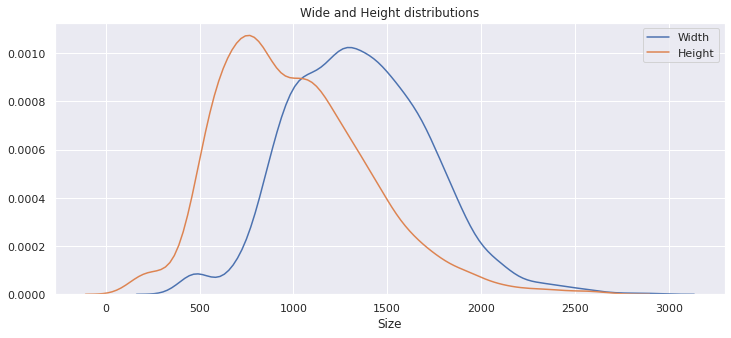

In [8]:
plt.figure(figsize=(12,5))

sns.kdeplot(np.array(dim)[:,0], label='Width' );
sns.kdeplot(np.array(dim)[:,1], label='Height' );
plt.title('Wide and Height distributions')
plt.xlabel('Size')
plt.legend();
# np.array(dim[:17])[:,0]

To have a better idea about what we are working with, we use [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) which is a very nice python package that easily allows to read images from files.

The matrix representation of one of the images is (1144, 1674, 3)


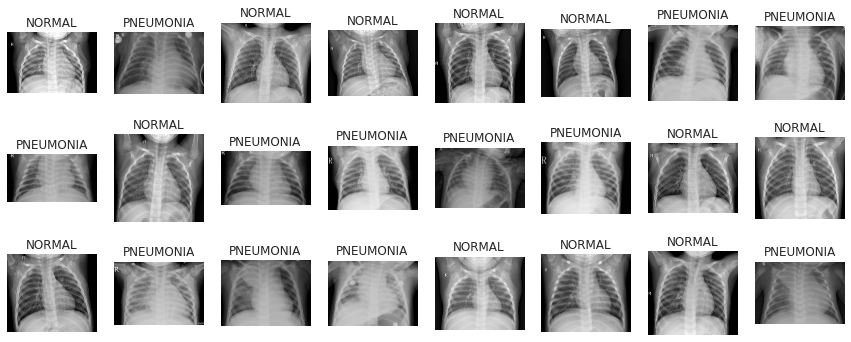

In [9]:
import cv2 # Computer vision tasks such as reading image from file, changing color channels

def view_image(image): # Function to view an image
    image_cv = cv2.imread(image) 
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)); 
    plt.axis('off');
# view_image(Data[50]); #view a single image

#To know the dimensions of one of these images as a matrix, use
print('The matrix representation of one of the images is '+ str( cv2.imread(Data_train[0]).shape) )

# Plot the first N images
n_rows = 3
n_cols = 8
N = n_rows*n_cols
plt.figure(figsize=(15,6))
for i, image in enumerate(Data_train[:N]):
  plt.subplot(n_rows, n_cols, i+1)
  view_image(image)
  plt.title(labels_name[y_train[i]] ) # This is when we use the labels_name 😎

From these images it seems like having the overall brightness of the X-Ray and some extended white regions tell us something important. Most likely it tells us that there's some sort of liquid in the lungs dispersing the light.

# Data preprocessing

First thing in the preprocessing is to resize our images and make a numpy array from them, which we'll use for the CNN.

**NB:** on the first few runs we were using all the RAM memory from Google Colab. Ideally we would like to leave the images with the biggest possible size, however, we need to reduce our sample to a portion of its original size and resize the image to use less space.



In [10]:
new_size = 300
sample_number = int(len(Data_train)*.8)

X_train= []
for img_path in tqdm(Data_train[:sample_number] ):
    image = cv2.imread(img_path)
    X_train.append(cv2.resize(image,(new_size, new_size)))

X_val= []
for img_path in tqdm(Data_val):
    image = cv2.imread(img_path)
    X_val.append(cv2.resize(image,(new_size, new_size)))

X_test= []
for img_path in tqdm(Data_test):
    image = cv2.imread(img_path)
    X_test.append(cv2.resize(image,(new_size, new_size)))

# Make them numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = y_train[:sample_number]

100%|██████████| 624/624 [00:09<00:00, 66.90it/s]


Now that we have the images as arrays, the easiest way to show them is:

This is an image is of a 1 patient


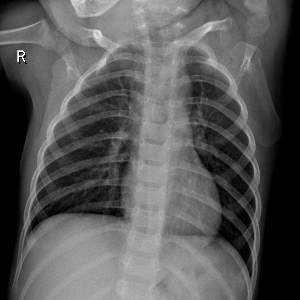

In [11]:
print('This is an image is of a {} patient'.format(y_val[0]))
Image.fromarray(X_val[0], 'RGB')

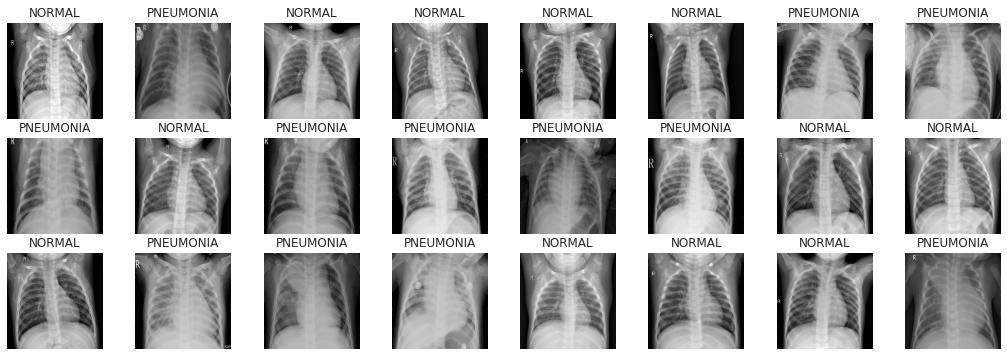

In [12]:
# Plot the first N images
n_rows = 3
n_cols = 8
N = n_rows*n_cols
plt.figure(figsize=(18,6))

# plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)); 
#     plt.axis('off');

for i, array in enumerate(X_train[:N]):
  plt.subplot(n_rows, n_cols, i+1)
  # view_image(Image.fromarray(array, 'RGB'))
  plt.imshow(Image.fromarray(X_train[i], 'RGB') )
  plt.axis('off');
  plt.title(labels_name[y_train[i]] ) # This is when we use the labels_name 😎

# Creating the CNN

We will work with a basic convolutional NN model, described below.


In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(new_size, new_size, 3)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Flatten(), # Step to go from convolution to regular dense NN
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10,  activation='softmax') # Maybe a sigmoid activation is better?
] )
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary() # Great way to know what we're doing

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 614656)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               78676096  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 78,682,250
Trainable params: 78,682,250
Non-trainable params: 0
_________________________________________________________________


## Fitting and testing the model

In [19]:
#Fit the CNN
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
131/131 [==============================] - 25s 189ms/step - loss: 267.6367 - accuracy: 0.8442 - val_loss: 8.8844 - val_accuracy: 0.7500
Epoch 2/10
131/131 [==============================] - 24s 187ms/step - loss: 0.9224 - accuracy: 0.9535 - val_loss: 7.4997 - val_accuracy: 0.7500
Epoch 3/10
131/131 [==============================] - 24s 186ms/step - loss: 0.5148 - accuracy: 0.9640 - val_loss: 1.5751 - val_accuracy: 0.9375
Epoch 4/10
131/131 [==============================] - 24s 187ms/step - loss: 1.0722 - accuracy: 0.9394 - val_loss: 3.8804 - val_accuracy: 0.8125
Epoch 5/10
131/131 [==============================] - 24s 187ms/step - loss: 0.6146 - accuracy: 0.9593 - val_loss: 1.7511 - val_accuracy: 0.8750
Epoch 6/10
131/131 [==============================] - 24s 187ms/step - loss: 0.3552 - accuracy: 0.9758 - val_loss: 1.3342 - val_accuracy: 0.8750
Epoch 7/10
131/131 [==============================] - 24s 186ms/step - loss: 0.2213 - accuracy: 0.9866 - val_loss: 1.2525 - val_

## Evaluating the model


 Let's test the model now

1/1 - 0s - loss: 6.7533e-05 - accuracy: 1.0000
The accuracy reached by the model is: 1.0


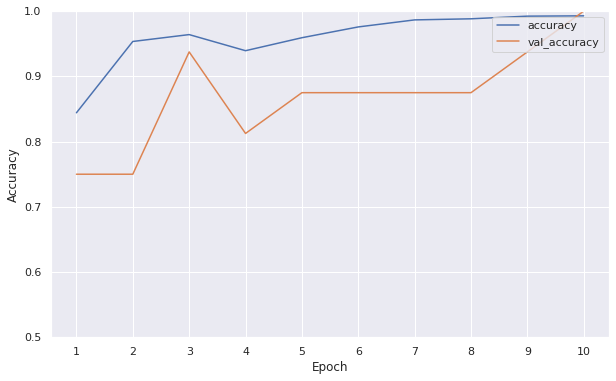

In [20]:
plt.figure(figsize=(10,6))
print("\n Let's test the model now\n")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.xticks(ticks=[i for i in range(10)], labels=[i+1 for i in range(10)])
plt.legend(loc='upper right');


test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2);
print('The accuracy reached by the model is: ' + str(test_acc))

## Model predictions 

Now, with unseen images we predict what label they would have according to what our model has learned. 

In [21]:
predictions_prob = model.predict(X_test)
predictions = np.array([np.argmax(predictions_prob[i]) for i in range(len(predictions_prob))])
accuracy = (predictions == y_test).sum()/len(y_test)
accuracy

0.7564102564102564

As we can see, this model guessed right around **74%** of the times.


# Summary

Even this basic CNN allows us to correctly predict  a fair percentage of the people with illness. Some caveats of this model are that
- We were not able to train the model with all the available images due to the google colab RAM cutoff.
- The population we fed to this model is not balanced and hence the model is biased towards predicting people with pneumonia.
- There is only one source of images. To be able to confidently state anything we would need to have several different resources to compare our results.